<a href="https://colab.research.google.com/github/jitender2622/Customer-churn-prediction/blob/main/Customer_churn_prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Install Gradio for the interactive app (quiet mode to hide logs)
!pip install -q gradio

# Import standard data manipulation libraries
import pandas as pd
import numpy as np

# Import visualization libraries
import matplotlib.pyplot as plt
import seaborn as sns

# Import Machine Learning tools from Scikit-Learn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

# Import SMOTE to handle imbalanced data (fix the ratio of Churn vs No Churn)
from imblearn.over_sampling import SMOTE

# Import Gradio for the final user interface
import gradio as gr

# Ignore annoying warning messages in the output
import warnings
warnings.filterwarnings('ignore')

In [ ]:
# Load the dataset directly from a GitHub URL
url = "https://raw.githubusercontent.com/IBM/telco-customer-churn-on-icp4d/master/data/Telco-Customer-Churn.csv"
df = pd.read_csv(url)

# Drop the CustomerID column as it is not useful for prediction
df.drop('customerID', axis=1, inplace=True)

# Convert TotalCharges to numeric, turning errors (empty strings) into NaN
df['TotalCharges'] = pd.to_numeric(df['TotalCharges'], errors='coerce')

# Remove rows that contain NaN (missing) values
df.dropna(inplace=True)

# Convert the target column 'Churn' from Yes/No to 1/0
df['Churn'] = df['Churn'].map({'Yes': 1, 'No': 0})

# Initialize the LabelEncoder
le = LabelEncoder()

# Loop through all columns that are type 'object' (text) and convert them to numbers
for col in df.select_dtypes(include='object').columns:
    df[col] = le.fit_transform(df[col])

# Show the first 5 rows to verify
df.head()

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,0,0,1,0,1,0,1,0,0,2,0,0,0,0,0,1,2,29.85,29.85,0
1,1,0,0,0,34,1,0,0,2,0,2,0,0,0,1,0,3,56.95,1889.50,0
2,1,0,0,0,2,1,0,0,2,2,0,0,0,0,0,1,3,53.85,108.15,1
3,1,0,0,0,45,0,1,0,2,0,2,2,0,0,1,0,0,42.30,1840.75,0
4,0,0,0,0,2,1,0,1,0,0,0,0,0,0,0,1,2,70.70,151.65,1


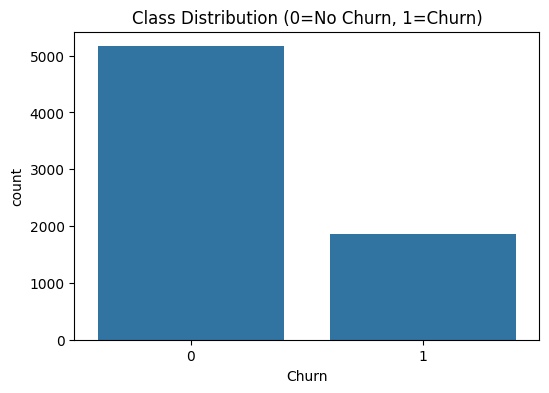

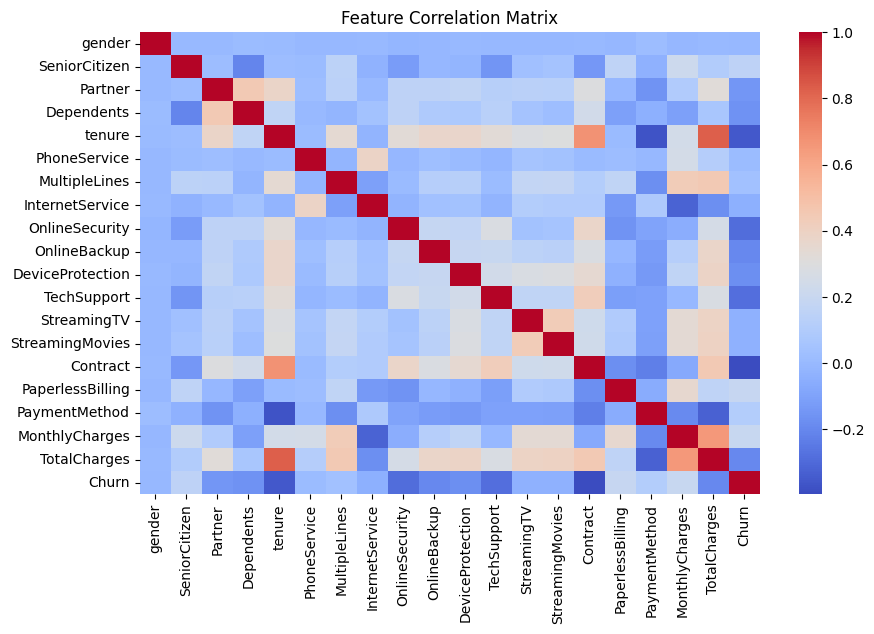

In [ ]:
# specific plot showing the balance of Churn vs No Churn
plt.figure(figsize=(6,4))
sns.countplot(x='Churn', data=df)
plt.title('Class Distribution (0=No Churn, 1=Churn)')
plt.show()

# Correlation Matrix Heatmap
plt.figure(figsize=(10,6))
sns.heatmap(df.corr(), annot=False, cmap='coolwarm')
plt.title('Feature Correlation Matrix')
plt.show()

In [ ]:
# Define X (features/questions) and y (target/answer)
X = df.drop('Churn', axis=1)
y = df['Churn']

# Split data into Training (80%) and Testing (20%) sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Apply SMOTE to balance the training data (creates synthetic Churners)
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

# Initialize the Random Forest Classifier
model = RandomForestClassifier(random_state=42, n_estimators=100)

# Train the model on the balanced data
model.fit(X_train_resampled, y_train_resampled)
print("Model Training Complete.")

Model Training Complete.


Accuracy: 0.7683013503909026

Classification Report:
               precision    recall  f1-score   support

           0       0.84      0.84      0.84      1033
           1       0.56      0.56      0.56       374

    accuracy                           0.77      1407
   macro avg       0.70      0.70      0.70      1407
weighted avg       0.77      0.77      0.77      1407



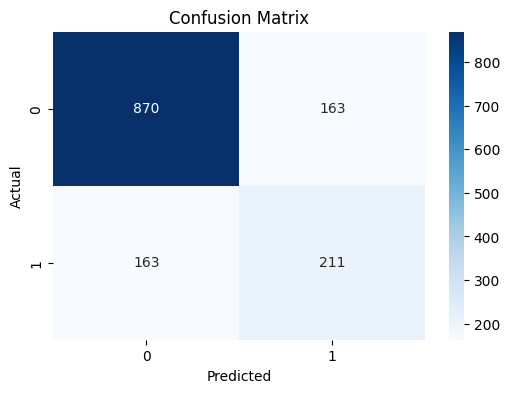

In [ ]:
# Use the trained model to predict outcomes for the test set
y_pred = model.predict(X_test)

# Print the accuracy score
print("Accuracy:", accuracy_score(y_test, y_pred))

# Print the detailed classification report
print("\nClassification Report:\n", classification_report(y_test, y_pred))

# Plot the Confusion Matrix
plt.figure(figsize=(6,4))
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

In [ ]:
# Define a function to handle predictions from the Gradio interface
def predict_churn(MonthlyCharges, TotalCharges, Tenure):
    # Create a dummy row with all zeros matching the model's expected shape
    input_data = pd.DataFrame(np.zeros((1, len(X.columns))), columns=X.columns)

    # Update the dummy row with the specific user inputs
    input_data['MonthlyCharges'] = MonthlyCharges
    input_data['TotalCharges'] = TotalCharges
    input_data['tenure'] = Tenure

    # Get the prediction (0 or 1)
    prediction = model.predict(input_data)[0]

    # Get the probability (confidence score)
    probability = model.predict_proba(input_data)[0][1]

    # Return a readable string based on the prediction
    if prediction == 1:
        return f"High Risk of Churn \n(Confidence: {probability:.2%})"
    else:
        return f"Low Risk of Churn \n(Confidence: {probability:.2%})"

# Setup the visual interface
interface = gr.Interface(
    fn=predict_churn,
    inputs=[
        gr.Slider(0, 150, label="Monthly Charges ($)"),
        gr.Slider(0, 9000, label="Total Charges ($)"),
        gr.Slider(0, 72, label="Tenure (Months)")
    ],
    outputs="text",
    title="Customer Churn Predictor",
    description="Adjust sliders to see the churn risk."
)

# Launch the app
interface.launch()

It looks like you are running Gradio on a hosted Jupyter notebook, which requires `share=True`. Automatically setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://3a71fe4e646baffeed.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)
